# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

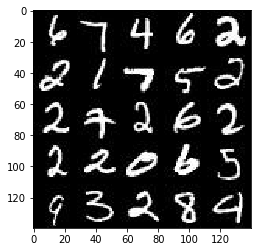

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

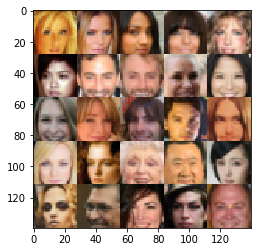

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #input layer real image is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # leaky relu
        x1 = tf.maximum(x1 * alpha, x1)
        # now it is 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        # batch norm
        x2 = tf.layers.batch_normalization(x2, training=True)
        # learky relu
        x2 = tf.maximum(x2 * alpha, x2)
        # now it is 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        # batch norm
        x3 = tf.layers.batch_normalization(x3, training=True)
        # leaky relu
        x3 = tf.maximum(x3 * alpha, x3)
        # now it is 4x4x256
        
        # flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # first fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # reshape
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(x1 * alpha, x1)
        # now it is 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)
        # now it is 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3 * alpha, x3)
        # now it is 16x16x128
        
        
        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # now it is 32x32x3
        
        out = tf.tanh(logits)
        
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learn_rate: learning_rate })
                _ = sess.run(g_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learn_rate: learning_rate })
 
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
            
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2112... Generator Loss: 17.6791
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 17.1536
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 13.0370
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.3730
Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 1.6744
Epoch 1/2... Discriminator Loss: 0.2528... Generator Loss: 2.1483
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.1203... Generator Loss: 4.3166


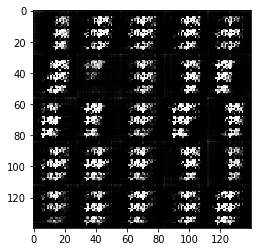

Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 1.7746
Epoch 1/2... Discriminator Loss: 0.4304... Generator Loss: 6.2810
Epoch 1/2... Discriminator Loss: 4.2391... Generator Loss: 12.8426
Epoch 1/2... Discriminator Loss: 0.2063... Generator Loss: 4.1101
Epoch 1/2... Discriminator Loss: 0.3124... Generator Loss: 2.0390
Epoch 1/2... Discriminator Loss: 0.4225... Generator Loss: 7.0326
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 0.1844... Generator Loss: 3.2117
Epoch 1/2... Discriminator Loss: 0.1529... Generator Loss: 3.6121
Epoch 1/2... Discriminator Loss: 0.6527... Generator Loss: 1.7583


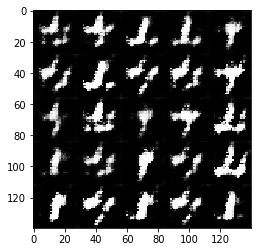

Epoch 1/2... Discriminator Loss: 0.1859... Generator Loss: 2.8054
Epoch 1/2... Discriminator Loss: 0.2355... Generator Loss: 3.1906
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 2.4821
Epoch 1/2... Discriminator Loss: 0.1781... Generator Loss: 6.9080
Epoch 1/2... Discriminator Loss: 0.2661... Generator Loss: 2.9666
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 0.2712... Generator Loss: 5.4675
Epoch 1/2... Discriminator Loss: 0.2418... Generator Loss: 2.3168
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 5.1082
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.4230


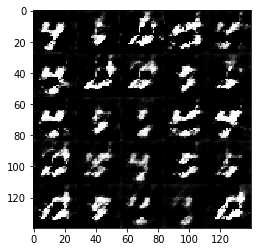

Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 4.5531
Epoch 1/2... Discriminator Loss: 0.7126... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 3.3893
Epoch 1/2... Discriminator Loss: 0.4410... Generator Loss: 1.9563
Epoch 1/2... Discriminator Loss: 0.6411... Generator Loss: 1.1525
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 4.0137
Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.4261
Epoch 1/2... Discriminator Loss: 0.3347... Generator Loss: 3.8189
Epoch 1/2... Discriminator Loss: 0.3020... Generator Loss: 2.8395
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 4.1714


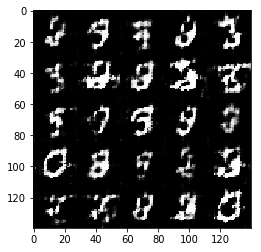

Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 2.5980
Epoch 1/2... Discriminator Loss: 0.4578... Generator Loss: 3.0356
Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 2.0073
Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 1.0881
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.6648
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 1.5635


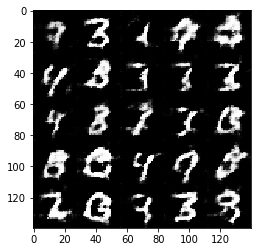

Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.9073
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 1.6040
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.3224
Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 1.8702
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 2.3907
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 2.9872
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.6540


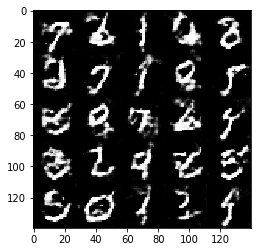

Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 2.1879
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.2746
Epoch 1/2... Discriminator Loss: 0.6098... Generator Loss: 1.7895
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 0.6784... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 3.4061
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 2.6645
Epoch 1/2... Discriminator Loss: 1.7743... Generator Loss: 3.4162


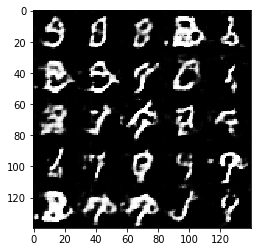

Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.6188
Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.9806
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 2.7826
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.4411
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 0.7984


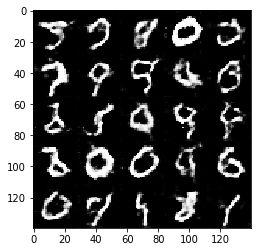

Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 1.7849
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 0.5156... Generator Loss: 2.0877
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 2.8637
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 3.0558
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 0.9747


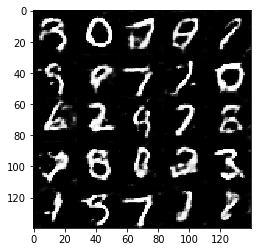

Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.8276
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.5642
Epoch 1/2... Discriminator Loss: 1.9477... Generator Loss: 3.4127
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.2145
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.4299
Epoch 2/2... Discriminator Loss: 1.5813... Generator Loss: 0.3514


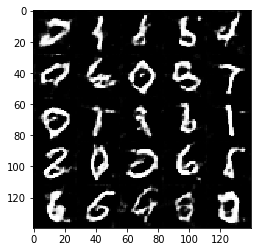

Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 1.8088
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.6318
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 0.5327... Generator Loss: 1.6805
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 0.7703... Generator Loss: 1.5493
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.2773


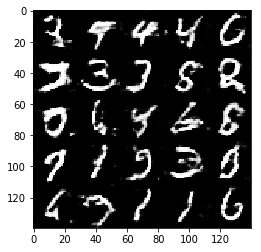

Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.0688
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 1.5365
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.5124
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 1.1781


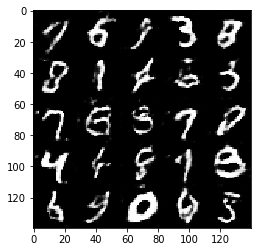

Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.5514
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.3708
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.7363
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.5295
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.6416
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.8799
Epoch 2/2... Discriminator Loss: 1.6575... Generator Loss: 0.2903
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.5171


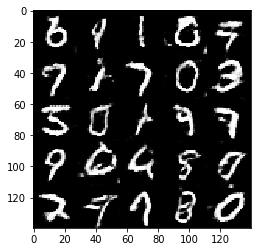

Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.0329
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.9338
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.4115
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.1884
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 2.0253
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.4527
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.1541


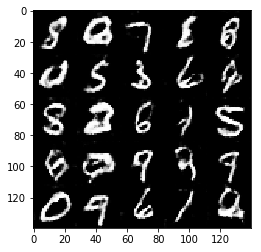

Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.4587
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 1.7577
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.4933


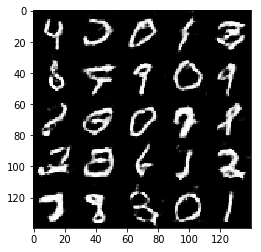

Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.1695
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.7376
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.5664
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 1.4196
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.4701
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 1.4046


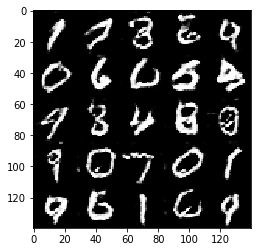

Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 1.8128... Generator Loss: 0.2614
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 1.6256
Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 1.5386
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.6530
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.3828
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 1.9418
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 4.3268... Generator Loss: 6.0932


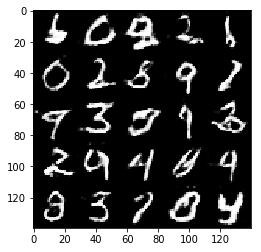

Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.9458
Epoch 2/2... Discriminator Loss: 0.5108... Generator Loss: 1.7714
Epoch 2/2... Discriminator Loss: 1.8942... Generator Loss: 0.2978
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.4400
Epoch 2/2... Discriminator Loss: 0.7067... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 1.5938... Generator Loss: 0.3420
Epoch 2/2... Discriminator Loss: 1.0344... Generator Loss: 2.2088


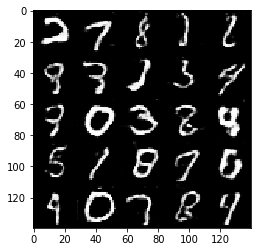

Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.9025... Generator Loss: 0.3006
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 0.9911


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 13.0023
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 12.4440
Epoch 1/1... Discriminator Loss: 1.8344... Generator Loss: 5.0967
Epoch 1/1... Discriminator Loss: 1.8912... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 3.9283
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 3.0746
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 8.1032


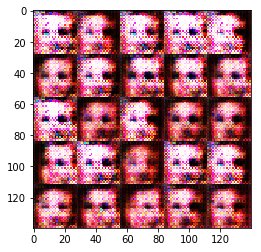

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 7.2199
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 4.3537
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 2.6067
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.7205
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.8850... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.9096


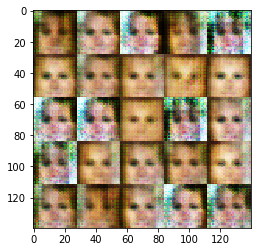

Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.0438


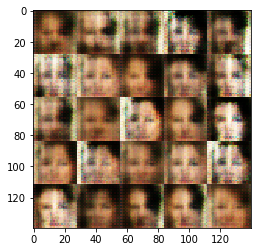

Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 1.0538


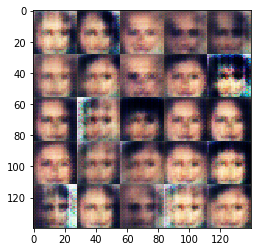

Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 2.3964... Generator Loss: 0.1513
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.9676


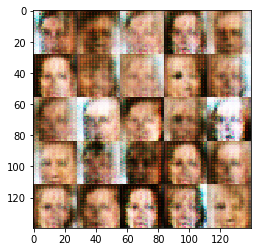

Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.5395
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.9397


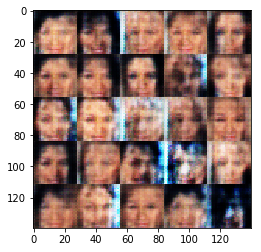

Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 2.1772... Generator Loss: 3.4937
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9857


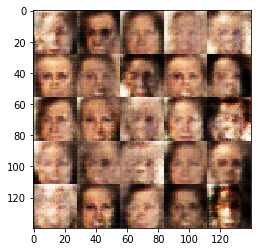

Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 2.3886
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.2884


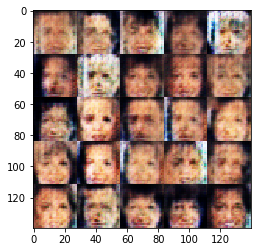

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 1.8280... Generator Loss: 2.5225
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 2.2779
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 2.5955
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.4264


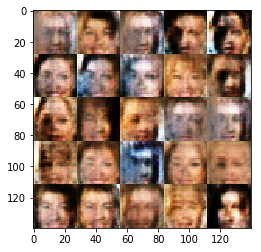

Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 2.0224
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 2.0656
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.4330
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 2.5326
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.2017


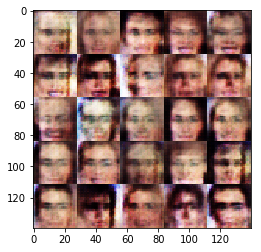

Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.5108
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.3648
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.9402
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.8167
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.8201


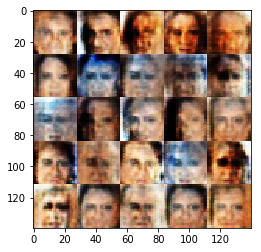

Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.4906
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.4199
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.5280


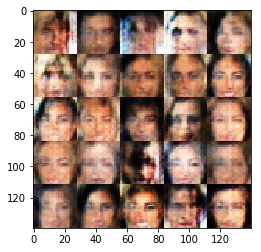

Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 2.1707
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3501


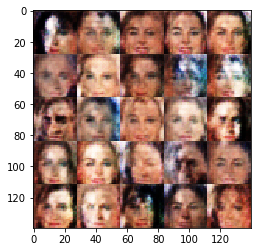

Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.8837
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 2.2368
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.4539


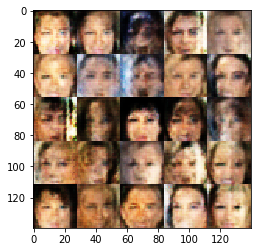

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9682


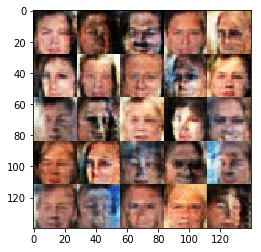

Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 2.5270
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 0.8676


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.